# Simulation of Quantum Chromodynamics and Nuclear Astrophysics

Core-collapse supernovae are among the most catostrophic events in the universe, and play an important role in cosmological history, providing an engine by which elements heavier than iron can be synthesized. Although supernovae are ultimately driven by the microscopic mechanisms in nuclear physics, their simulation naively appears to be a problem of classical physics of transport and fluid dynamics. However, these supernovae generate a tremendous number of neutrinos, with the bulk of the energy of the supernova being carried away by the neutrinos.

For a complete treatment of the physics of a supernova, it is critical to determine the exact momentum. At such
large densities, traditional classical computational methods of kinetic theory become impractical, as
it is necessary to determine the time-evolution of the full many-body density matrix, and recently,
much effort in the field has been devoted to using quantum computation and quantum information
science as a way forward.

Tracing out a static nuclear and electron background that the neutrinos are embedded in, the Hamiltonian for our system is the following:
$$\hat{H} = \hat{H}_1 + \hat{H}_2 $$
$$\hat{H}_1 = \sum_{f, f'}\sum_{s, s'} \int d^3 \vec{p}B_{ff',ss'}(t, \vec{p})\hat{a}_{f,s}^\dagger(\vec{p})\hat{a}_{f',s'\vec{p}}$$
$$\hat{H}_2 = \sum_{f_1,f_2,f_3,f_4}\sum_{s_1,s_2,s_3,s_4} \int d^3\vec{p_1}d^3\vec{p_2}d^3\vec{p_3}d^3\vec{p_4}C(\vec{p_1}^{f_1s_1},\vec{p_2}^{f_2s_2},\vec{p_3}^{f_3s_3},\vec{p_4}^{f_4s_4})\delta^{(3)}\bigg( \sum_{i}\vec{p_i}\bigg) $$

$$\times \hat{a}^{\dagger}_{f_3,s_3}(\vec{p_3})\hat{a}_{f_1,s_1}(\vec{p_1})\hat{a}^{\dagger}_{f_4,s_4}(\vec{p_4})\hat{a}_{f_2,s_2}(\vec{p_2})$$

The following describes the terms in the Hamiltonian:
- The operators $\hat{a}^{\dagger}_{f,s,\vec{p}}$,$\hat{a}_{f,s,\vec{p}}$ are fermionic creation and annihilation operators with anti-commutation relations that create and annihilate states of flavor f, spin s, and momentum $\vec{p}$
- The coefficients C for relativistic neutrinos is easily expressed in terms of helicity projected 2-spinors, as helicity and chirality dependence becomes identical, and is given as:
$$C(\vec{p_1}^f, \vec{p_2}^{f'}, \vec{p_3}^f, \vec{p_4}^{f'}) = \frac{G_f}{\sqrt{2}}\bra{p_1} \gamma^\mu \lvert p_3] \bra{p_2}\gamma_\mu \lvert p_4]  $$
- For neutrino-anti-neutrino annihilation we have:
  $$C(\vec{p_1}^f, \vec{p_2}^{f'}, \vec{p_3}^{f}, \vec{p_4}^{f'}) = \frac{G_F}{\sqrt{2}}\bra{p_1} \gamma^\mu \lvert p_2] \bra{p_3}\gamma_\mu \lvert p_4]  $$
- The Hamiltonians $\hat{H}_1$ and $\hat{H}_2$ represent the one and two-body neutrino Hamiltonians
  - The one body Hamiltonian includes the neutrino kinetic energy terms, the mass mixing matrix, and the interactions of neutrinos against any fixed background of nuclear or electron matter
- $G_F$ is the low energy coupling constant from the 4-Fermi effective theory of the standard model that results from integrating out the Z-boson

The primary goal of the theorist analyzing the problem is to calculate the final distribution of
momenta and flavors of the neutrinos given a specific initial distribution. The asymptotic flavor-dependent momentum spectrum is then defined as:
$$N_f(t, \vec{p}) = tr\bigg[\hat{a}^{\dagger}_{f}(\vec{p})\hat{a}_{f}(\vec{p})e^{it\hat{H}}\hat{\rho}e^{-it\hat{H}} \bigg], \text{as } t \gg T_{sn} $$
where:
- $\hat{\rho}$ is the initial density matrix of all the neutrinos
- t is the time scale 
- $T_{sn}$ is the time scale where we can expect the neutrinos will escape the supernova, and the neutrino-neutrino and neutrino-matter interactions will become irrelevant, as the matter and neutrino densities plummet


However, a lower bound to the computational gate complexity of our Hamiltonian can be provided by considering a simplified case of the neutrino scattering Hamiltonian known as the forward scattering model. As the forward scattering model is a strict subset of the full problem, any gate count and qubit requirements for the forward scattering problem lower bounds the difficulty of the full problem.

In the integrals over all possible momenta, we consider two decisions:
1. $\vec{p_1} = -\vec{p_3}$ and $\vec{p_2} = -\vec{p_1}$
2. $\vec{p_1} = -\vec{p_4}$ and $\vec{p_2} = -\vec{p_3}$
which represents the forward/back-scattering scenarios.

This model comes with several more restrictions:
- Neglect anti-neutrinos
- Restrict to a two-flavor model
- Fix the number of momentum nodes to be the number of neutrinos, N=K

We can then write the Hamiltonian as an all-to-all Heisenberg model, yielding
$$\hat{H} = \sum_{i=1}^{N}\vec{b_i} \cdot \hat{\vec{\sigma_{i}}} + \frac{G_{F}\mu}{\sqrt{2}N} p_i \cdot p_j \hat{\vec{\sigma_i}} \cdot \hat{\vec{\sigma_{j}}} $$

Where now N is the number of neutrinos or equivalently momentum nodes, and $\vec{b}_i$ is the one-body coupling matrix, $\vec{p}_i$ is the momentum of the i-th neutrino, $\mu$ is the density of neutrinos, which we can take to be 1 with a redition of time after setting the one-body terms to zero, and $\hat{\vec{\sigma_i}}$ is a Pauli matrix operating on the flavor space of the i-th momentum mode. 

With an all-to-all connected architecture, the simplest Trotterization of this Hamiltonian yields a circuit with N depth for a single trotter step.

In [40]:
from random import uniform

import cirq

import numpy as np

import matplotlib as plt

import networkx as nx

from qca.utils.algo_utils import estimate_trotter
from qca.utils.hamiltonian_utils import flatten_nx_graph, pyliqtr_hamiltonian_to_openfermion_qubit_operator

from pyLIQTR.utils.Hamiltonian import Hamiltonian as pyH

# Initial State Preparation
A reasonable initial state is a product state, which for each neutrino is Gaussian distributed over momenta, with the momentum peaked at the nuclear scales at which the neutrinos are generated, i.e, 1 - 10 MeV. Product states suffice due to the uncorrelated production of the neutrinos, and the gaussian distribution localizes the neutrinos to specific regions of the supernova.

For determining a good initial state that provides information over how the thermalization proceeds as function of the inititla total spin along the z-direction, there are five cases we can consider. Despite their being more exotic states that we can consider, such states are irrelevant for this task. These five possible initial states are:
1. 50% qubits up state and the rest down
2. 60% qubits up state and the rest down
3. 70% qubits up state and the rest down
4. 80% qubits up state and the rest down
5. 90% qubits up state and the rest down

As such, we can clearly see that the cost for preparing the initial state is a constant, depth 1 operation. 

In [8]:
def initial_state_prep(n_qubits:int, spin_up_percent:float) -> cirq.Circuit:
    qubits_spin_up = int(spin_up_percent*n_qubits)
    qubits = [cirq.LineQubit(idx) for idx in range(qubits_spin_up)]
    spin_up_portion = [cirq.X(qb) for qb in qubits]

    circuit = cirq.Circuit()
    circuit.append(spin_up_portion)
    return circuit

initial_state_prep(10, 0.5)

0: ───X───

1: ───X───

2: ───X───

3: ───X───

4: ───X───

# Dynamics

The simplest case that can prove to be of scientific use will be to consider a gas of momentum plane-wave neutrinos, undergoing two-body interactions without a complicating matter background, in the relativistic limit. Then the one-body Hamiltonian reduces reduces to the identity, being the conserved total kinetic energy of the system. Thus, the goal will be to see how equilibration is reached for flavor distribution of a single momentum mode for a given distribution of initial neutrino momenta and flavors.

We first need to initialize the couplings. We know the following:
$$p_i \cdot p_j = 1 - \vec{p}_i \cdot \vec{p}_j$$
$$\lvert \lvert \vec{p}_i \rvert \rvert = 1 \quad \forall_i$$
$$\vec{p}_i = (p_i^x, p_i^y, p_i^z) $$

We have two cases:
- Spherical distributed: $\vec{p}_i$ is uniform on the sphere
- Gaussian distributed: $\vec{p}_i$ is Gaussian about a direction
  
Let Pr(x) mean "probability of x". To accomplish spherical, for each i, draw 3 random numbers x, y, z gaussian distributed:
- Pr(x) $\propto exp(-x^2) $
- Pr(y) $\propto exp(-y^2) $
- Pr(z) $\propto exp(-z^2) $
  
Set: $\vec{p_i} = \frac{1}{\sqrt{x^2 + y^2 + z^2}}(x, y, z)$

To accomplish guassian:

For each i, draw 2 random numbers $\theta, \phi$ distributed as:

- Pr($\theta$) $\propto \Theta(\pi - \theta)exp(-\theta^2/\sigma_2) $
- Pr($\phi$) uniform between [0, $2\pi$]
Set: $\vec{p}_i = (sin\theta cos\phi, sin\theta sin\phi, cos\theta)$

Note that we want $\sigma \ll \pi/2$, so we can take it to be 0.25 for definiteness

In [26]:
def generate_spherical_momentum() -> list[float]:
    x = np.exp(-uniform(0, 1)**2)
    y = np.exp(-uniform(0, 1)**2)
    z = np.exp(-uniform(0, 1)**2)
    constant = 1/(np.sqrt(x**2 + y**2 + z**2))
    ith_momentum = [
        constant*x,
        constant*y,
        constant*z
    ]
    return ith_momentum

Once we understand how to generate the momentum for a given neutrino, we can use this to generate our Heisenberg Hamiltonian.

{((0, 0),
  (0,
   1)): Text(1.3877787807814457e-17, 0.4999994125973899, '0.03891339352566672'),
 ((0, 0), (1, 0)): Text(0.5000065820931924, 0.0, '0.027263309106315716'),
 ((0, 1), (1, 1)): Text(0.5000065820931924, 1.0, '0.011127314073745327'),
 ((1, 0),
  (1,
   1)): Text(1.0000000000000002, 0.4999994125973899, '0.001871390240766612')}

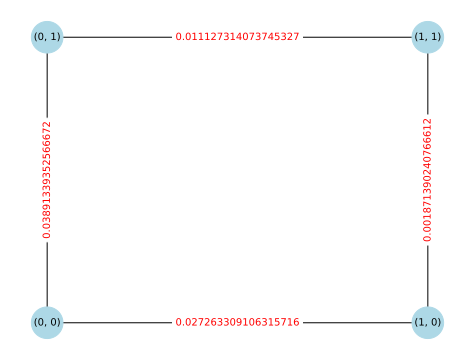

In [46]:
def define_forward_scattering_term(n_neutrinos, curr_momentum, neighbor_momentum) -> float:
    normalization_factor = 1/(np.sqrt(2)*n_neutrinos)
    couplings = 1 - np.inner(curr_momentum, neighbor_momentum)
    normalized_couplings = normalization_factor*couplings
    return normalized_couplings

def gen_couplings(n_neutrinos: int, curr_coords: tuple[int], neighbor_coords: tuple[int], momentum: dict) -> float:
    curr_momentum = momentum[curr_coords]
    neighbor_momentum = momentum[neighbor_coords]
    return define_forward_scattering_term(
        n_neutrinos=n_neutrinos,
        curr_momentum=curr_momentum,
        neighbor_momentum=neighbor_momentum
    )

def nx_heisenberg_terms(g:nx.Graph) -> list:
    hamiltonian = []
    n = len(g.nodes)
    for (n1, n2, d) in g.edges(data=True):
        weight = d['weight']
        pauli_string = n * 'I'
        for pauli in ['X', 'Y', 'Z']:
            for i in range(len(g)):
                if i == n1 or i == n2:
                    pauli_string = f'{pauli_string[:i]}{pauli}{pauli_string[i+1:]}'
                hamiltonian.append((pauli_string, weight))
        
    return hamiltonian

def generate_heisenberg_graph(n_neutrinos: int, site_interaction:float=0) -> nx.Graph:
    graph = nx.Graph()
    momentum = {}
    for i in range(n_neutrinos):
        for j in range(n_neutrinos):
            coords = (i, j)
            graph.add_node(coords, weight=site_interaction)
            momentum[coords] = generate_spherical_momentum()

    for node in graph.nodes:
        r, c = node
        coords = (r, c)
        if (r, c+1) in graph:
            neighbor_coords = (r, c+1)
            coupling_terms = gen_couplings(
                n_neutrinos=n_neutrinos,
                curr_coords=coords,
                neighbor_coords=neighbor_coords,
                momentum=momentum
            )
            graph.add_edge(node, (r, c+1), weight=coupling_terms)

        if (r+1, c) in graph:
            neighbor_coords = (r+1, c)
            coupling_terms = gen_couplings(
                n_neutrinos=n_neutrinos,
                curr_coords=coords,
                neighbor_coords=neighbor_coords,
                momentum=momentum
            )
            graph.add_edge(node, (r+1, c), weight=coupling_terms)
    return graph

def generate_hamiltonian(n_neutrinos: int, site_interactions:float=0):
    graph = generate_heisenberg_graph(
        n_neutrinos=n_neutrinos,
        site_interaction=site_interactions
    )
    flat_graph = flatten_nx_graph(graph)
    H = nx_heisenberg_terms(flat_graph)
    return H

neutrino_graph = generate_heisenberg_graph(2)
pos = {node: node for node in neutrino_graph.nodes()}
edge_labels = nx.get_edge_attributes(neutrino_graph, 'weight')
nx.draw(neutrino_graph, pos, with_labels=True, node_size=1000, font_size=10, node_color = 'lightblue', font_color = 'black')
nx.draw_networkx_edge_labels(neutrino_graph, pos, edge_labels=edge_labels, font_color='red')

After generating our hamiltonian, we perform quantum evolution until the required momentum spectra reaches an equilibrium value. The equilibrium value can be deduced as a steady state value in time of the momentum spectra, where moment to moment fluctuations are small relative to the long-time averaged observable. For this notebook, we will be using a second order trotterization.

In [44]:
h_neutrino = generate_hamiltonian(2)
h_neutrino_pyliqtr = pyH(h_neutrino)
qb_op_hamiltonian = pyliqtr_hamiltonian_to_openfermion_qubit_operator(h_neutrino_pyliqtr)
estimate_trotter(
    qb_op_hamiltonian,
    1.02,
    1e-3,
    'QCD/',
    hamiltonian_name='forward_scattering',
    nsteps=1
)

Time to find term ordering: 8.699996396899223e-05 seconds
Time to generate trotter circuit from openfermion: 1.0838266462087631e-06 seconds
Time to generate a clifford + T circuit from trotter circuit: 0.15129958419129252 seconds


┌──┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       ┌──┐                   ┌──┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       ┌──┐                              ┌──┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          ┌──┐                              ┌──┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          ┌──┐               